# Single-cell RNA-seq analysis workflow using Scanpy on CPU

Copyright (c) 2020, NVIDIA CORPORATION.  All rights reserved.

NVIDIA CORPORATION and its licensors retain all intellectual property
and proprietary rights in and to this software, related documentation
and any modifications thereto.  Any use, reproduction, disclosure or
distribution of this software and related documentation without an express
license agreement from NVIDIA CORPORATION is strictly prohibited.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
from timeit import default_timer as timer
import pandas as pd
import time
import sys
import os
from sklearn.cluster import KMeans

## Set parameters

In [2]:
# marker genes
RIBO_GENE_PREFIX = "RPS" # Prefix for ribosomal genes to regress out
markers = ["ACE2", "TMPRSS2", "EPCAM"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
n_top_genes = 5000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 20 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Louvain
louvain_resolution = 0.4

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

# Number of parallel jobs for t-SNE and k-means
n_jobs=32

In [3]:
start = time.time()

## Load and Prepare Data

In [4]:
# Add path to input file here.
input_file = "krasnow_hlca_10x_UMIs.sparse.h5ad"

In [5]:
%%time
adata = sc.read(input_file)
adata = adata.T

CPU times: user 3.33 s, sys: 989 ms, total: 4.32 s
Wall time: 4.32 s


## Preprocessing

In [6]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [7]:
%%time
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)
adata.shape

CPU times: user 1.68 s, sys: 2.62 s, total: 4.3 s
Wall time: 4.33 s


(65462, 26485)

Some genes will now have zero expression in all cells. We filter out such genes.

In [8]:
%%time
sc.pp.filter_genes(adata, min_cells=1)

CPU times: user 1.33 s, sys: 1.02 s, total: 2.35 s
Wall time: 2.35 s


### Normalize

In [9]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 499 ms, sys: 234 ms, total: 733 ms
Wall time: 732 ms


In [10]:
%%time
sc.pp.log1p(adata)

CPU times: user 1.42 s, sys: 19.3 ms, total: 1.44 s
Wall time: 1.44 s


### Select Most Variable Genes

In [11]:
%%time
# Filter matrix to only variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor="cell_ranger")

# Retain marker gene expression
for marker in markers:
    adata.obs[marker+"_raw"]= adata.X[:, adata.var.index==marker].todense()

adata = adata.copy()
n_genes = sum(adata.var.highly_variable)
print("Selected " + str(n_genes) + " genes.")
adata = adata[:, adata.var.highly_variable]

Selected 5000 genes.
CPU times: user 2.22 s, sys: 907 ms, total: 3.13 s
Wall time: 3.13 s


### Regress out confounding factors (number of counts, ribosomal gene expression)

In [12]:
ribo_genes = adata.var_names.str.startswith(RIBO_GENE_PREFIX)

In [13]:
%%time
n_counts = np.array(adata.X.sum(axis=1))
adata.obs['percent_ribo'] = np.array(np.sum(adata[:, ribo_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

Trying to set attribute `.obs` of view, copying.


CPU times: user 1.1 s, sys: 240 ms, total: 1.34 s
Wall time: 1.34 s


In [14]:
%%time
sc.pp.regress_out(adata, ['n_counts', 'percent_ribo'])

### Scale

In [15]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 3.69 s, sys: 545 ms, total: 4.24 s
Wall time: 4.24 s


In [16]:
preprocess_time = time.time()
print("Total Preprocess time (includes data load): %s" % (preprocess_time-preprocess_start))

Total Preprocess time (includes data load): 230.46386432647705


## Cluster & Visualize

In [17]:
cluster_start = time.time()

### Reduce

In [18]:
%%time
# PCA
sc.tl.pca(adata, n_comps=n_components)

CPU times: user 25.1 s, sys: 2.19 s, total: 27.3 s
Wall time: 19.5 s


### TSNE + K-means

In [19]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs, n_jobs=n_jobs)

CPU times: user 1h 15min 11s, sys: 3min 51s, total: 1h 19min 3s
Wall time: 2min 50s


In [20]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0, n_jobs=n_jobs).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 4.41 s, sys: 1.68 s, total: 6.09 s
Wall time: 3.45 s


... storing 'kmeans' as categorical


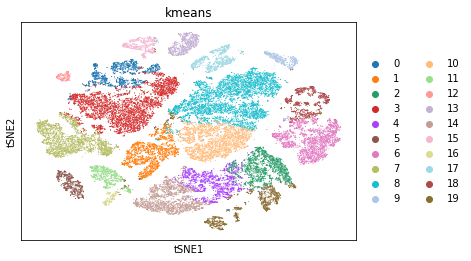

CPU times: user 487 ms, sys: 21.9 ms, total: 509 ms
Wall time: 507 ms


In [21]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

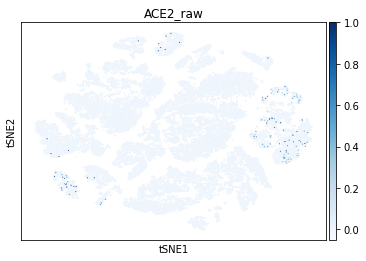

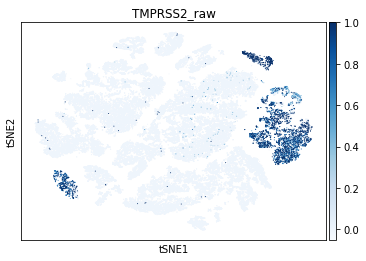

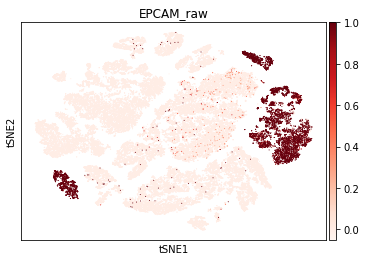

CPU times: user 873 ms, sys: 14.1 ms, total: 887 ms
Wall time: 881 ms


In [22]:
%%time
sc.pl.tsne(adata, size=4, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1,  vmin=-0.05)

### UMAP + Louvain

In [23]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 19.2 s, sys: 1.68 s, total: 20.9 s
Wall time: 20.7 s


In [24]:
%%time
# UMAP
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 6min 12s, sys: 21.3 s, total: 6min 33s
Wall time: 1min 10s


In [25]:
%%time
# Louvain clustering
sc.tl.louvain(adata, resolution=louvain_resolution)

CPU times: user 11.1 s, sys: 178 ms, total: 11.3 s
Wall time: 11.3 s


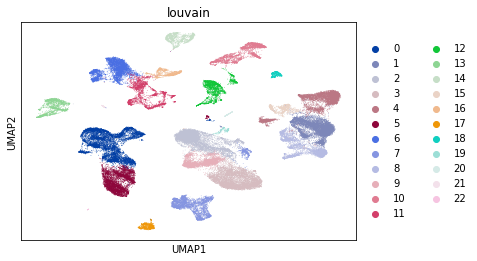

CPU times: user 478 ms, sys: 14.1 ms, total: 492 ms
Wall time: 490 ms


In [26]:
%%time
# Plot
sc.pl.umap(adata, color=["louvain"])

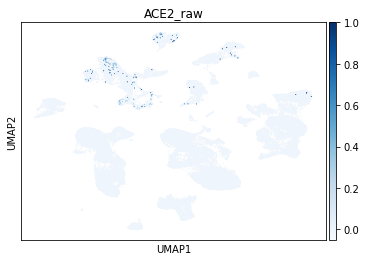

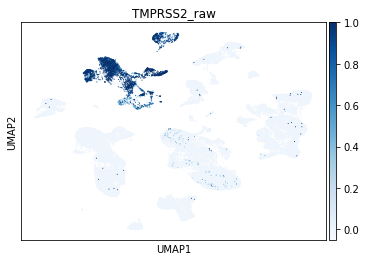

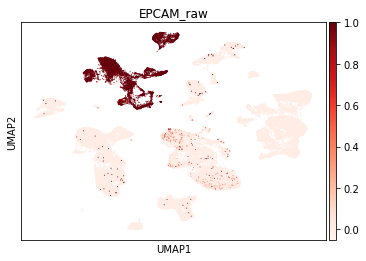

CPU times: user 1.07 s, sys: 66.9 ms, total: 1.14 s
Wall time: 1.13 s


In [27]:
%%time
sc.pl.umap(adata, size=4,color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1, vmin=-0.05)

In [28]:
cluster_time = time.time()
print("Total cluster time : %s" % (cluster_time-cluster_start))

Total cluster time : 299.33984303474426


## Differential expression analysis

In [29]:
%%time
sc.tl.rank_genes_groups(adata, groupby="louvain", n_genes=ranking_n_top_genes, groups='all', reference='rest')

/share/software/miniconda3/envs/rapids-env7/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:252: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


CPU times: user 1min 10s, sys: 19.6 s, total: 1min 30s
Wall time: 1min 30s


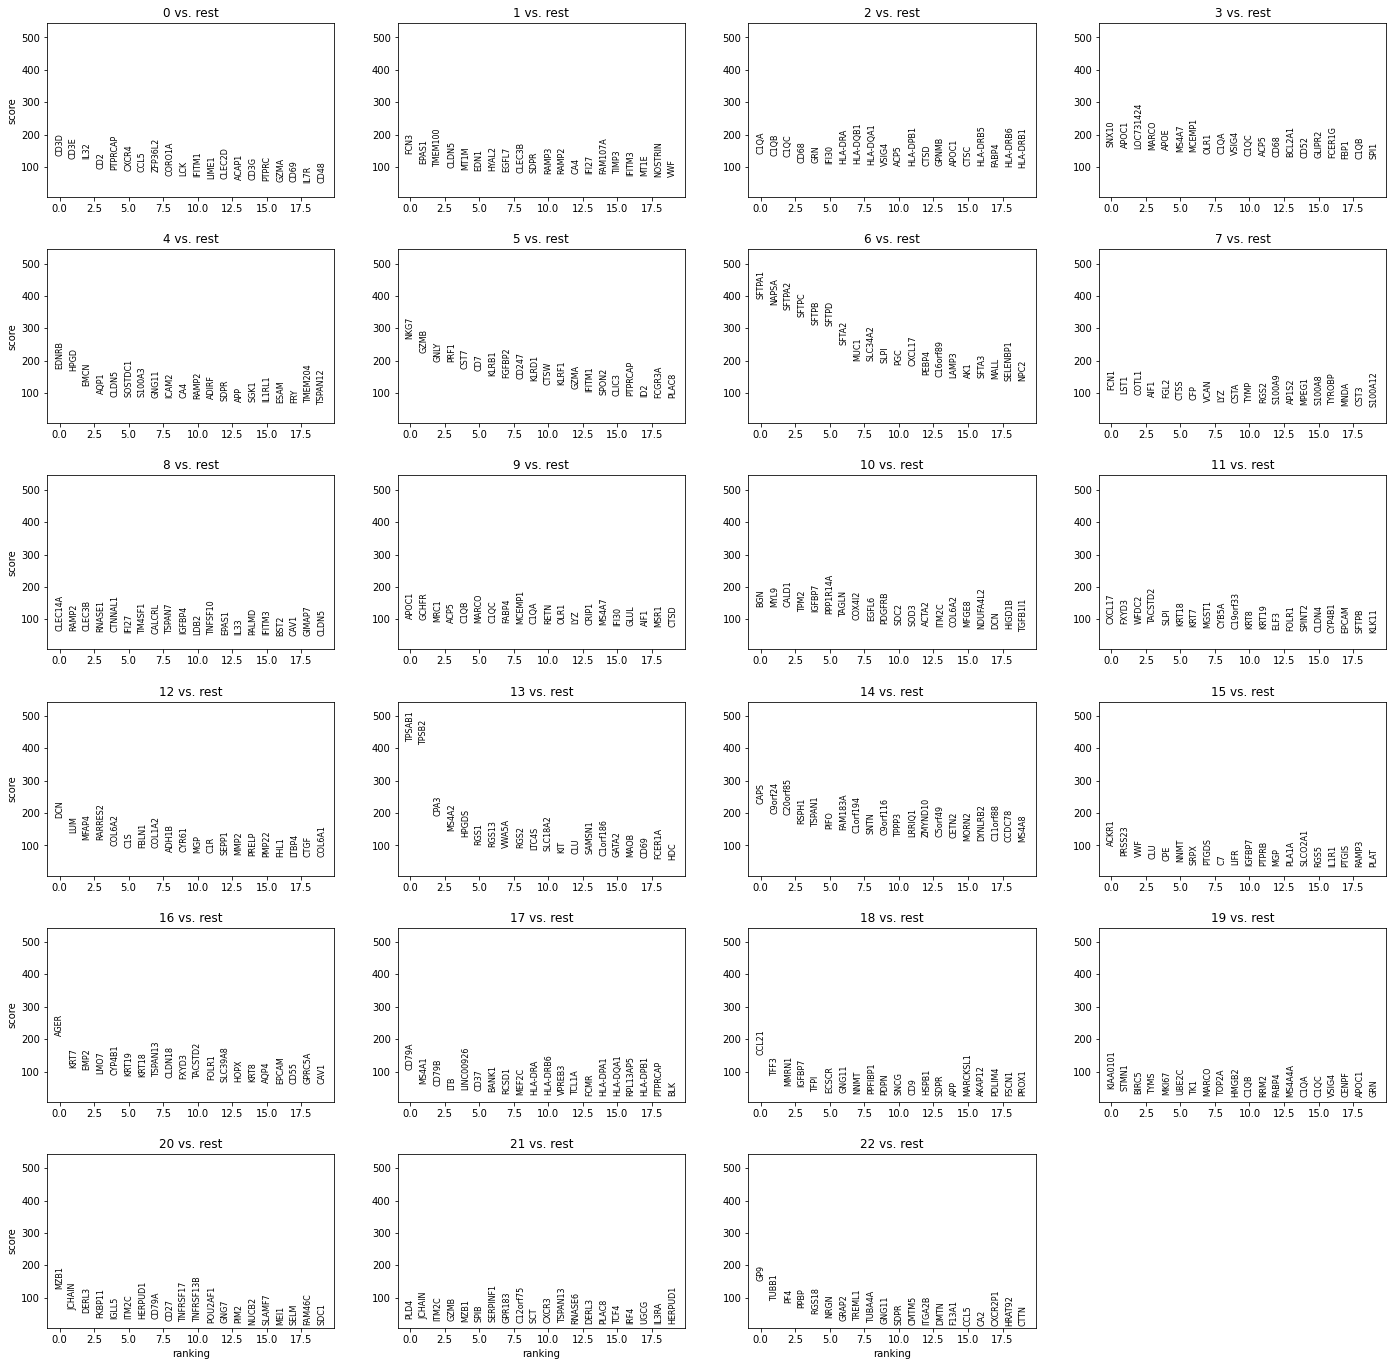

CPU times: user 2.9 s, sys: 89.1 ms, total: 2.99 s
Wall time: 2.98 s


In [30]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [31]:
total_time = time.time() - start

## Create zoomed-in view

In [32]:
reanalysis_start = time.time()

In [33]:
%%time

adata = adata[adata.obs["EPCAM_raw"] > 0.0, :]
print(adata.X.shape)

(7958, 5000)
CPU times: user 343 ms, sys: 49 ms, total: 392 ms
Wall time: 392 ms


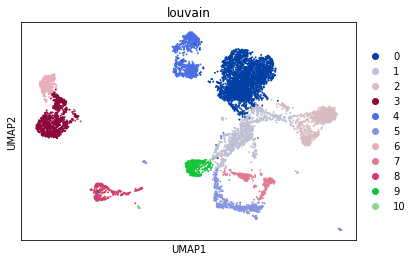

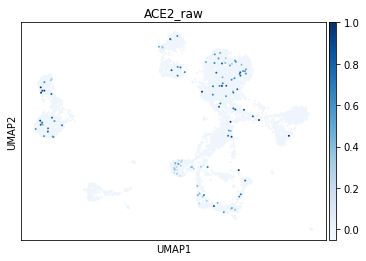

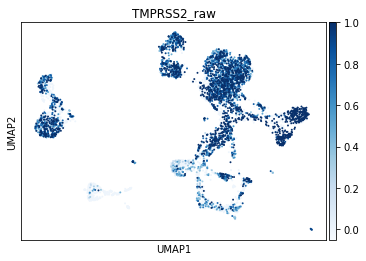

CPU times: user 37.1 s, sys: 1.28 s, total: 38.4 s
Wall time: 21.3 s


In [34]:
%%time
sc.tl.pca(adata, n_comps=n_components)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)
sc.tl.louvain(adata, resolution=louvain_resolution)

sc.pl.umap(adata, color=["louvain"])
sc.pl.umap(adata, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [35]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 21.750110626220703


In [36]:
print("Full time: %s" % (time.time() - start))

Full time: 649.5613198280334
